# Multimodal RAG using Bedrock Titan and Claude3

## Install dependencies

In [ ]:
!sudo apt-get update -y
!sudo apt -y install poppler-utils tesseract-ocr
!sudo apt install ffmpeg libsm6 libxext6  -y

In [ ]:
!pip install pdf2image
!pip install pytesseract
!pip install -U langchain langchain-experimental langchain-aws
!pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch
!pip install -U faiss-cpu tiktoken

## Download and process dataset

In [2]:
import os
import shutil

!wget "https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf" --no-check-certificate
shutil.move("0892360224.pdf","input.pdf")

--2024-06-28 15:52:44--  https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf
Resolving www.getty.edu (www.getty.edu)... 108.138.64.3, 108.138.64.100, 108.138.64.52, ...
Connecting to www.getty.edu (www.getty.edu)|108.138.64.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18838661 (18M) [application/pdf]
Saving to: ‘0892360224.pdf’

0892360224.pdf      100%[===================>]  17.97M  26.1MB/s    in 0.7s    

2024-06-28 15:52:46 (26.1 MB/s) - ‘0892360224.pdf’ saved [18838661/18838661]



'input.pdf'

In [6]:
path = "mm-rag/"
file_name = os.listdir(path)

In [ ]:
file_name

In [5]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename='input.pdf',
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))
#
print(len(tables))
print(len(texts))

2
194


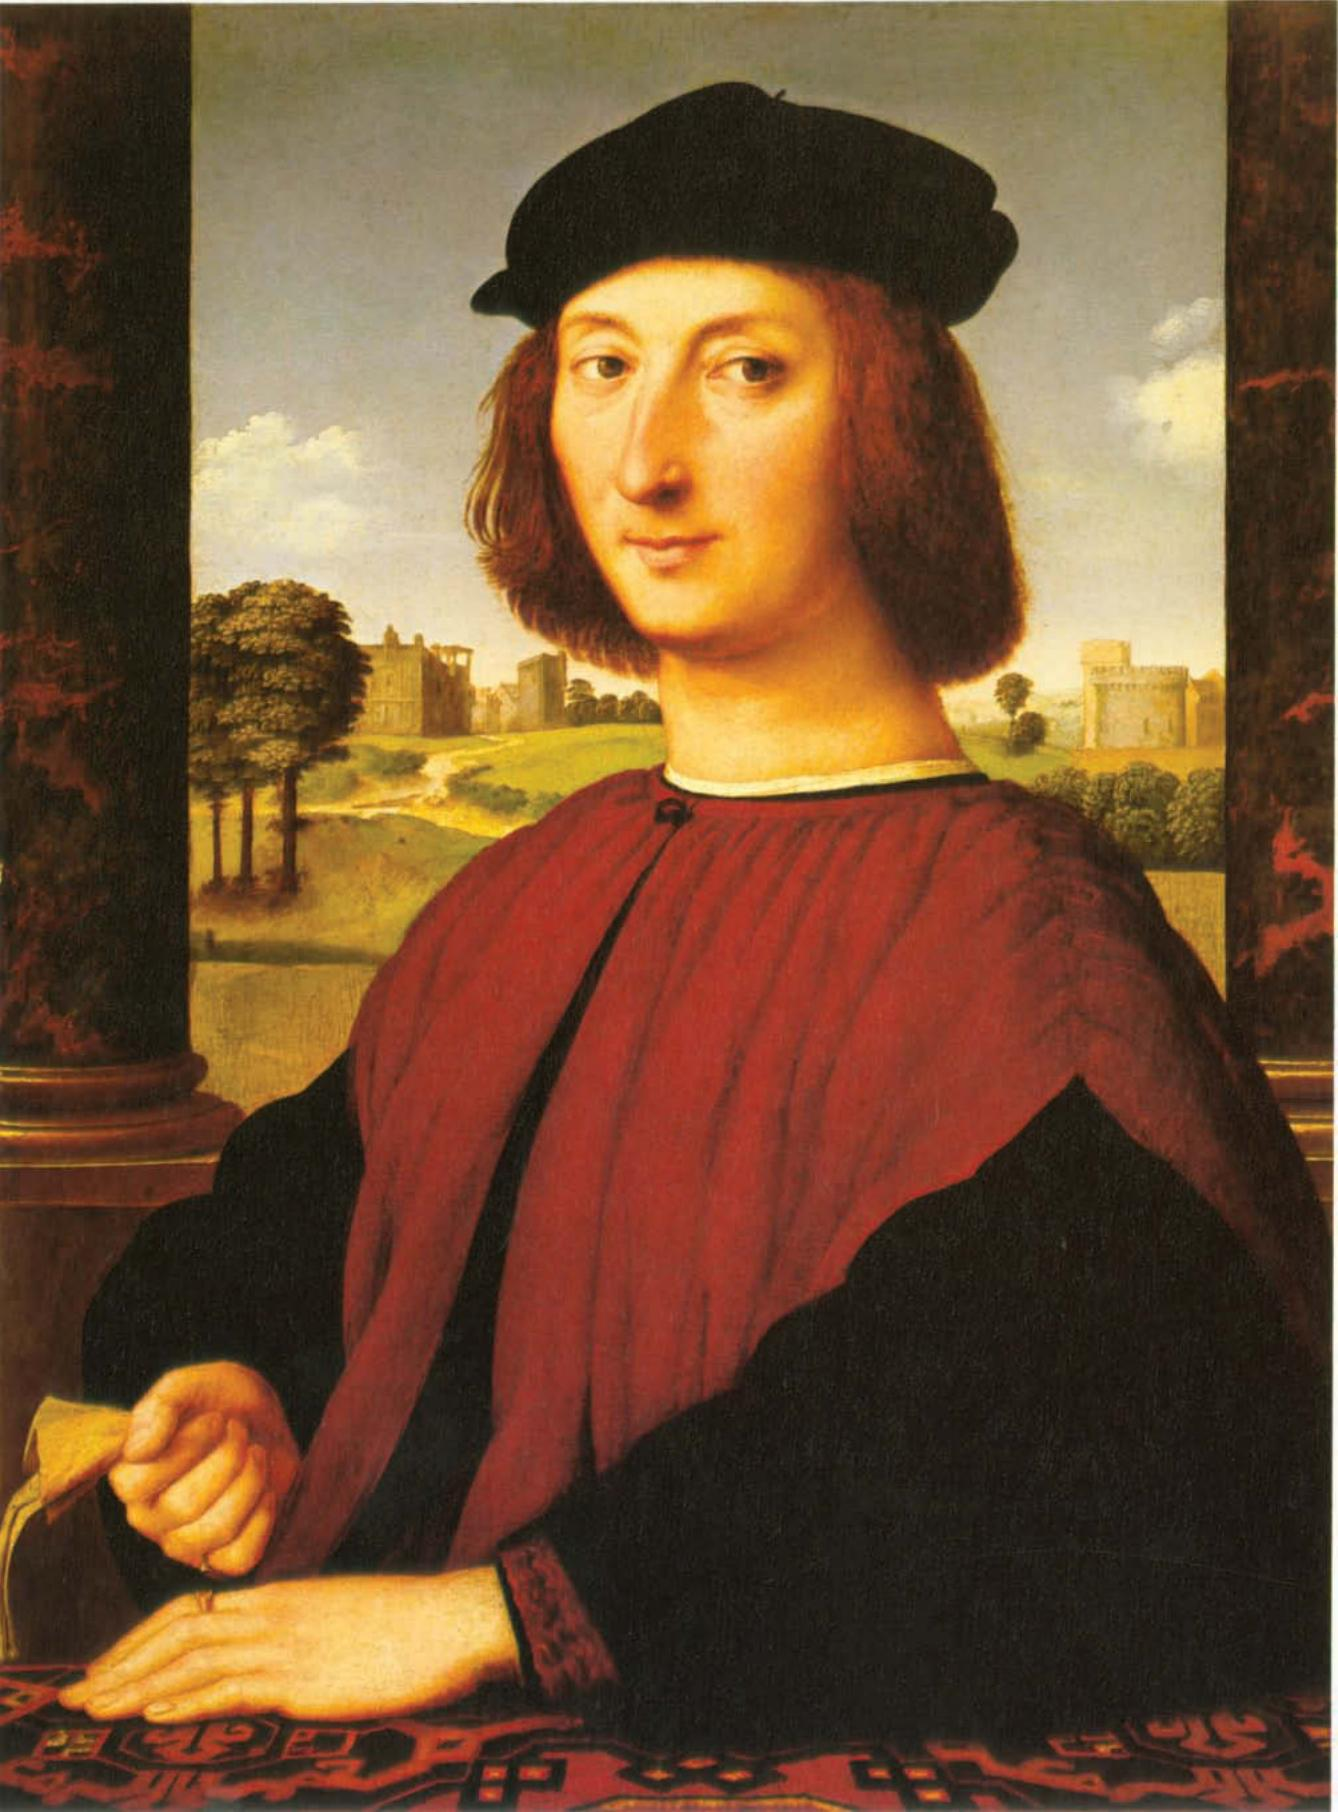

In [8]:
from PIL import Image
Image.open("mm-rag/figure-26-1.jpg")

## Import texts and images embedding to Faiss vector database

In [9]:
# Ensure the quality of texts
texts = [text for text in texts if len(text) > 20]
print(len(texts))

119


In [10]:
# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

In [12]:
import boto3

client = boto3.client("bedrock-runtime")

In [13]:
import json
import base64

def base64_encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf8')

def generate_embeddings(image_base64=None, text_description=None):
    input_data = {}

    if image_base64 is not None:
        input_data["inputImage"] = image_base64
    if text_description is not None:
        input_data["inputText"] = text_description

    if not input_data:
        raise ValueError("At least one of image_base64 or text_description must be provided")

    body = json.dumps(input_data)

    response = client.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )

    response_body = json.loads(response.get("body").read())

    finish_reason = response_body.get("message")

    if finish_reason is not None:
        raise EmbedError(f"Embeddings generation error: {finish_reason}")

    return response_body.get("embedding")

In [14]:
# Generate images embedding using Titan multimodal embedding
images_embeddings = []
for image in image_uris:
    embedding = (image, generate_embeddings(image_base64=base64_encode_image(image)))
    images_embeddings.append(embedding)

In [15]:
import os
import uuid

import numpy as np
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import BedrockEmbeddings
from PIL import Image as _PILImage


embeddings = BedrockEmbeddings(client=client, model_id='amazon.titan-embed-image-v1')

# Create Faiss vector store
vectorstore = FAISS.from_texts(texts, embeddings)

In [16]:
# print vectors dimension and vector counts before add images embedding
dimension = vectorstore.index.d
print(f"Dimension of vectors in the index: {dimension}")
print("Vector counts:", vectorstore.index.ntotal)

Dimension of vectors in the index: 1024
Vector counts: 119


In [17]:
# Add images embedding
vectorstore.add_embeddings(images_embeddings)

print("Vector counts:", vectorstore.index.ntotal)

retriever = vectorstore.as_retriever()

Vector counts: 247


In [ ]:
"""
# Delete vectors
print("count before:", vectorstore.index.ntotal)

for i in range(34):
    vectorstore.delete([vectorstore.index_to_docstore_id[i]])
"""

In [18]:
# Try similartiy search between text and images
docs_and_scores = vectorstore.similarity_search_with_score("Moses and the Messengers from Canaan")
docs_and_scores

[(Document(page_content='GIOVANNI  LANFRANCO Rome, 1582-1647 Moses  and  the  Messengers from  Canaan oil on canvas, 218 x246.3 cm 15  Between 1621 and 1625 Lanfranco executed a series of eight large paintings and three frescoes for the Cappella del Sacramento in the church of S. Paolo Fuori le Mura in Rome. They illustrated  stories from  the Old and New Testaments  that related  to the sacraments. The present  canvas belonged to the series and was hung high on the left wall just next to the entrance to the chapel. The  subject, which is rare, comes from  the book of  Numbers in which Moses sent spies into Canaan to find whether the land bore fruit.  After  forty days they returned with pomegranates, figs, and grapes. The  subject was chosen because the grapes were considered  a préfiguration of the wine drunk at  the Last Supper,  the  subject that hung to the right of our painting. Next  to that was Elias Fed a Loaf  of Bread by the Widow  ofSarepta,  a painting that is also in the 

## Build Multimodal RAG

In [19]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(image_path, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img = Image.open(image_path)

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_image(s):
    """Check if a string is Base64 encoded"""
    try:
        return s.endswith(".jpg") 
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_image(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [20]:
from operator import itemgetter

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough,RunnableParallel


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

In [21]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [22]:
from langchain_aws import ChatBedrock

# Using Bedrock Claude3
model = ChatBedrock(
    client=client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    model_kwargs={"temperature": 0.1, "max_tokens": 1024},
)

# RAG pipeline
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableParallel({"response":prompt_func| model| StrOutputParser(),
                      "context": itemgetter("context"),})
)

Based on the provided image and text, I will provide a comprehensive analysis:

Visual Description:
The image depicts a circular tondo painting featuring the Madonna and Child surrounded by two saints and a kneeling male donor figure. The Madonna is seated on an ornate throne, holding the Christ Child on her lap. To her right is St. Catherine, identifiable by her attribute of a spiked wheel. On the left is St. Jerome, recognizable by his cardinal's robes and the lion at his feet. The kneeling donor figure, likely a wealthy patron, is positioned in the foreground. The background shows a landscape with a body of water and trees. Two coats of arms are suspended from the throne, suggesting the patron's noble status.

Historical and Cultural Context:
The painting is attributed to the Master of the Lathrop Tondo, an anonymous artist active in Lucca, Italy, in the late 15th to early 16th century. The style and influence of Ghirlandaio and Filippino Lippi are evident. The coats of arms belong 


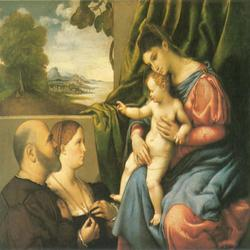

In [23]:
# Retrieve related images and texts then invoke Claude3 to generate answer
response = chain.invoke("Madonna and Child with Two Saints and a Donor")
print(response['response'])
plt_img_base64(response['context']['images'][0])

In [24]:
# check context
print(response['context'])

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAD6APoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCDfL/z0fH+8aUPL18x/wDvo0ruZHYlfypgY5YDtxzXA2krsVm3ZEyrK4zvc4+tNJkA5d/zNbenXtskQiZArYBLetVr82ruzwv82eRis1UizR02jNzJ/wA9G/M0pMgAJdsfU07PamPn0rSxmMJkPJds9ua17TR